In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np

from utils import seed_everything, Timer

In [2]:
seed_everything(0xbebebe)

In [3]:
# LeNet architecture
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
# CIFAR-10
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# model
net = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
# Training
for epoch in range(10):  #
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader)}")

print("Finished Training")

Epoch 1, Loss: 2.228949116928803
Epoch 2, Loss: 1.8087570674888922
Epoch 3, Loss: 1.5919678403288506
Epoch 4, Loss: 1.4885765468068135
Epoch 5, Loss: 1.4152528808244964
Epoch 6, Loss: 1.356753668211915
Epoch 7, Loss: 1.2962772907198543
Epoch 8, Loss: 1.2497422779002763
Epoch 9, Loss: 1.2066078564090192
Epoch 10, Loss: 1.1730591019858485
Finished Training


In [7]:
# Testing
def evaluate_cifar(net):
    net.eval()
    all_labels = []
    all_predictions = []

    with Timer('inference', True) as timer:
        with torch.inference_mode():
            for data in testloader:  #
                inputs, labels = data
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                all_labels.extend(labels.tolist())
                all_predictions.extend(predicted.tolist())

    # Metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    # Confusion matrix
    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=testset.classes, yticklabels=testset.classes)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()



Inference | Elapsed time : 5.84
Accuracy: 0.5844
Precision: 0.58437459514899
Recall: 0.5844
F1-Score: 0.5824897291413397


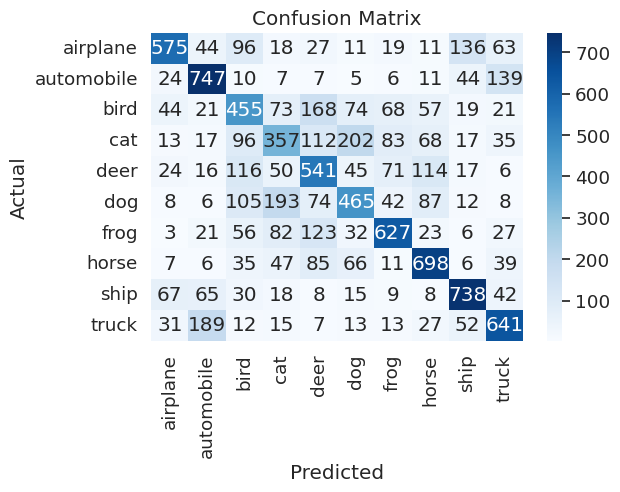

In [8]:
evaluate_cifar(net)

In [9]:
torch.save(net, 'lenet.pt')

In [10]:
print(f'LeNet size is {os.path.getsize("lenet.pt") / 2 ** 10:.1f} Kb')

LeNet size is 246.9 Kb


# ONNX

In [ ]:
!pip install transformers onnxruntime onnx datasets

In [22]:
import torch.onnx
import onnx
import onnxruntime

# input shape for CIFAR-10
dummy_input = torch.randn(1, 3, 32, 32)
onnx_path = "LeNet.onnx"
torch.onnx.export(net, dummy_input, onnx_path, # where to save the model
                  opset_version=14, # the ONNX version to export the model to
                  input_names=["input"],# the model's input names
                  output_names=["output"],# the model's outputs names
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [23]:
# ONNX model and ONNX runtime session
ort_session = onnxruntime.InferenceSession(onnx_path)

In [24]:
def evaluate_onnx_model(ort_session):
    ort_session.set_providers(['CPUExecutionProvider'])

    all_labels = []
    all_predictions = []

    with Timer('inference', True) as timer:
        for data in testloader:
            inputs, labels = data
            inputs = inputs.numpy()
            outputs = ort_session.run(None, {"input": inputs})[0]
            predicted = np.argmax(outputs, axis=1)
            all_labels.extend(labels.tolist())
            all_predictions.extend(predicted.tolist())

    # Metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    # Confusion matrix
    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=testset.classes, yticklabels=testset.classes)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix with onnx')
    plt.show()


Inference | Elapsed time : 7.70
Accuracy: 0.5844
Precision: 0.58437459514899
Recall: 0.5844
F1-Score: 0.5824897291413397


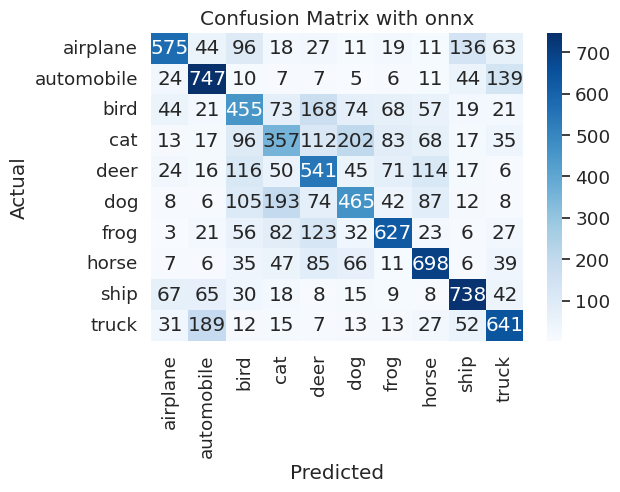

LeNet.onnx size is 243.9 Kb


In [25]:
evaluate_onnx_model(ort_session)
print(f'LeNet.onnx size is {os.path.getsize(onnx_path) / 2 ** 10:.1f} Kb')

# Openvino



In [ ]:
!pip install openvino-dev

In [27]:
from openvino.runtime import serialize
from openvino.tools import mo
import numpy as np
from scipy.special import softmax
from openvino.runtime import Core

ov_model = mo.convert_model('LeNet.onnx', compress_to_fp16=True)
serialize(ov_model, './openvino_model/LeNet.xml')

In [28]:
core = Core()
# compile model for loading on device
compiled_model = core.compile_model(ov_model)


In [30]:
def evaluate_openvino_model(exec_net):
    all_labels = []
    all_predictions = []

    with Timer('inference', True) as timer:
      for data in testloader:
          inputs, labels = data
          outputs = compiled_model(inputs)[0]
          predicted = np.argmax(outputs, axis=1)
          all_labels.extend(labels)
          all_predictions.extend(predicted)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Print and visualize metrics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    # Confusion matrix
    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=testset.classes, yticklabels=testset.classes)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


Inference | Elapsed time : 9.28
Accuracy: 0.5843
Precision: 0.5843464756994302
Recall: 0.5843
F1-Score: 0.5824137144803105


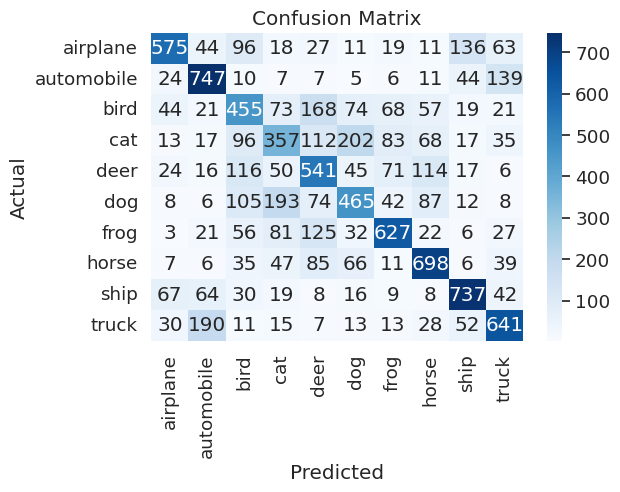

LeNet.bin size is 121.1 Kb
LeNet.xml size is 19.0 Kb


In [31]:
evaluate_openvino_model(compiled_model)
print(f'LeNet.bin size is {os.path.getsize("./openvino_model/LeNet.bin") / 2 ** 10:.1f} Kb')
print(f'LeNet.xml size is {os.path.getsize("./openvino_model/LeNet.xml") / 2 ** 10:.1f} Kb')

**PyTorch:**.
- Время вывода: 5,84 секунды
- Размер модели: 246,9 Кб
- Accuracy: 0.5844
- Precision: 0.5844
- Recall: 0.5844
- F1-Score: 0.5825

**ONNX:**
- Время вывода: 7,70 секунды
- Размер модели: 243,9 Кб
- Accuracy: 0.5844
- Precision: 0.5844
- Recall: 0.5844
- F1-Score: 0.5825

**OpenVINO:**
- Время вывода: 9,28 секунды
- Размер модели: 121,1 Кб (LeNet.bin), 19,0 Кб (LeNet.xml)
- Accuracy: 0.5843
- Precision: 0.5843
- Recall: 0.5843
- F1-Score: 0.5824


1. **Время вывода:**
   - PyTorch имеет самое быстрое время вывода, а OpenVINO - самое медленное. Такое различие может быть объяснено методами оптимизации, используемыми каждым фреймворком.
   - ONNX находится между PyTorch и OpenVINO по времени вывода, что говорит о том, что модель ONNX сохраняет некоторые характеристики производительности модели.

2. **Размер модели:**.
   - Наименьший размер модели имеет OpenVINO с отдельными bin- и xml-файлами. Модель ONNX имеет несколько больший размер, чем OpenVINO. PyTorch имеет самый большой размер модели. Меньший размер модели OpenVINO является преимуществом при хранении и развертывании.

3. **Метрики точности:**.
   - Показатели Accuracy, Precision, Recall и F1-Score одинаковы для всех трех методов. Это говорит о том, что производительность модели остается одинаковой независимо от используемого фреймворка.

**Плюсы использования ONNX:**
- ONNX является функционально совместимым форматом, позволяющим легко переключаться между различными фреймворками глубокого обучения.
- Он обеспечивает переносимость моделей, позволяя переносить их с одной платформы на другую с минимальными изменениями.
- Производительность близка к PyTorch, что говорит о том, что модель ONNX сохраняет большую часть эффективности исходной модели.

**Плюсы использования OpenVINO:**
- OpenVINO предоставляет инструменты для оптимизации моделей, делая их эффективными для вычислений на оборудовании Intel.
- Она поддерживает широкий спектр процессоров Intel, включая CPU, GPU и VPU.
- Размер модели меньше, что может быть полезно для развертывания в средах с ограниченными ресурсами.

PyTorch является самым быстрым, но может иметь больший размер модели. ONNX обеспечивает совместимость моделей. OpenVINO оптимизирует модели для эффективного вывода на оборудовании Intel, при этом размер модели меньше. Выбор метода зависит от ваших конкретных требований и целевой платформы развертывания. Если вам необходимо развертывание на оборудовании Intel, то предпочтительным вариантом может быть OpenVINO. Если же приоритетом является переносимость моделей, то отличным выбором может стать ONNX.